<a href="https://colab.research.google.com/github/MusliHyseni/CNN-klasifikimFotosh/blob/main/CNN_klasifikimFotosh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Rrjet neural konvolucional për klasifikim**
 ** Poshtë mund të shihni rrjetin neural konvolucional, të ndërtuar nga unë, Musli Hyseni, një **15-vjeçar** nga **Drenasi**.*

*Për çdo paqartësi, më kontaktoni në gmail: muslihyseni111@gmail.com, ose edhe në discord: musli.hyseni*

 Modeli është i specializuar për klasifikimin e objekteve nga 10 klasa *(aeroplanët, makinat, macet, zogjtë, drerët, qentë, bretkosat, kuajtë, anijet, dhe kamionët)*, dhe është trajnuar (dhe testuar) në foto të bashkësisë së të dhënave **CIFAR10**.

##  **Rrjeti klasifikon me saktësi 99.5%**
* Fotot kanë dimension `32x32 (px)`;
* Bashkësia e të dhënave është marrur nga moduli built-in i *Pytorch, torch.datasets*, si dataset a para-përpunuar, por mund të merret edhe nga platforma Kaggle (https://www.kaggle.com/datasets/valentynsichkar/cifar10-preprocessed).
*

Hapat e krijimit janë të shpjeguar, andaj kodi është i ndarë në fragmente.
**Le të fillojmë!**

## Së pari, marrim libraritë e nevojitura, modeli është ndërtuar në **Pytorch**, andaj ju lutem referohuni tek **dokumentacioni zyrtar** për marrjen e librarisë dhe për sintaksën e saj.

In [ ]:
"""
Ky është një rrjet neural për klasifikimin e objekteve
"""

# Marrim libraritë e nevojitura
import torch

from torch import nn
import torch.nn.functional as F

import torch.utils
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision
from torchvision import datasets
import torchvision.transforms as transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Rrjetet neurale përmbajnë hiperparametra (parametra të përkufizuar nga krijuesi i modelit, të cilët nuk optimizohen dhe qëndrojnë të njëjtë), të cilët po i përkufizojmë tani:

In [ ]:
# Përkufizojmë hiperparametrat
# Numri i sub-proceseve në marrjen e të dhënave
num_workers = 0

# Numri i shembujve për një bashkësi ("grumbull")
batch_size = 20

# Përqindja e bashkësisë së të dhënave, e cila përdoret për validim
valid_size = 0.2


### Përkufizimi i tranformës së të dhënave (aplikimin e saj e shihni pas pak)

In [ ]:
# Transformimi i input-it (fotove)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

### Marrim të dhënat nga `torch.datasets.CIFAR10`
### Ja edhe aplikimi i `tranform`

In [ ]:
# Të dhënat për trajnim
train_data = datasets.CIFAR10('data', train=True, download=True, transform=transform)

# Të dhënat për testim
test_data = datasets.CIFAR10('data', train=False, download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


### Krijojmë listë indeksesh, për ta ndarë bashkësinë e të dhënave

In [ ]:
# Numri i shembujve për trajnim
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)


### Ndajmë bashkësinë e trajnimit në atë të trajnimit (80%) dhe të validimit(20%)

In [ ]:
# Ndajmë dataset-in (0.8 ushtrim, 0.2 validim)
split = int(np.floor(valid_size * num_train))
# Ndarja
train_idx, valid_idx = indices[split:], indices[:split]

# Shembull-marrësit e përdorur për marrjen e "grumbujve"
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(valid_idx)

### Përkufizojmë marrësit e të dhënave, duke ia japur hiperparametrat

In [ ]:
# Marrësit e të dhënave
train_loader = torch.utils.data.DataLoader(train_data, batch_size, sampler=train_sampler, num_workers=num_workers, drop_last=True)
valid_loader = torch.utils.data.DataLoader(test_data, batch_size, sampler=test_sampler, num_workers=num_workers, drop_last=True)


### Klasat e bashkësisë, modeli merr një foto 30x30 si input, dhe jep njërën nga këto klasa si output.

In [ ]:
# Llojet(klasat) e fotove
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

### Fuksioni për vizualizimin e të dhënave

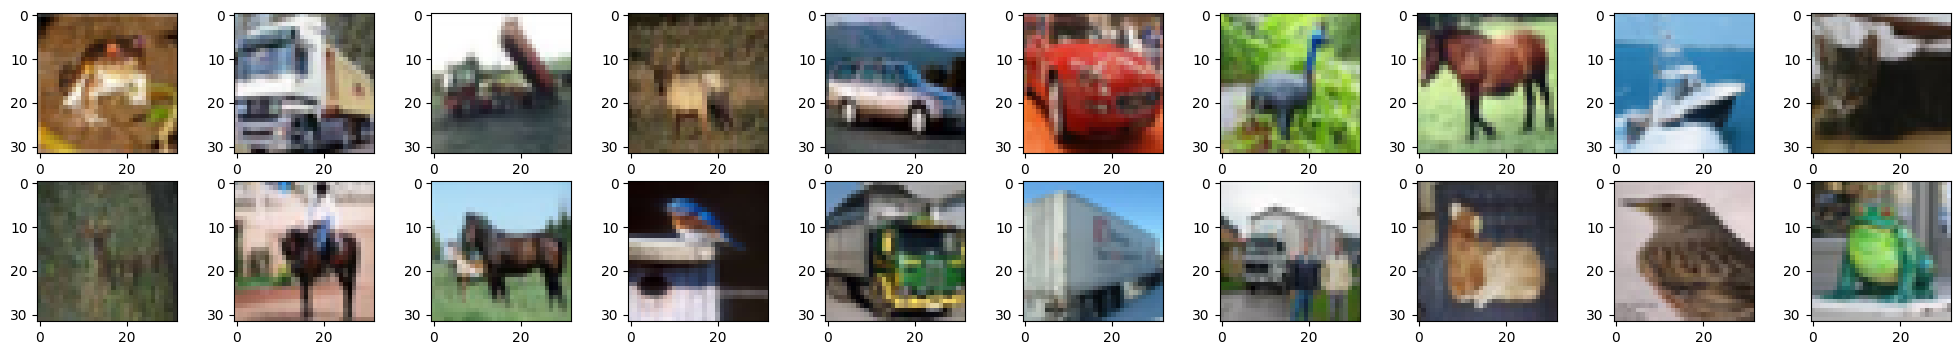

In [ ]:
# Funksioni për vizualizimin e fotove
def show_image(image):
    image = image / 2 + 0.5
    plt.imshow(np.transpose(image, (1, 2, 0)))

# I bëjmë të dhënat të iterueshme
images = []
iterable_data = iter(train_loader)
for i in range(20):
    image, label = train_loader.dataset[i]
    # Konvertojmë foton në numpy, për ta paraqitur
    image = image.numpy()
    # Vendosim foton në listën e fotove
    images.append(image)


# Përkufizojmë kornizën
fig = plt.figure(figsize=(25, 4))

# Fusim fotot në kornizë
for idx in np.arange(20):
    visual = fig.add_subplot(2, 10, idx+1)
    show_image(images[idx])

## Ja edhe pjesa kryesore, rrjeti neural, i cili përmban dy shtresa: shtresa konvolucionale - `self.conv_layer`, e cila përmban 3 blloqe konvolucionale, dhe shtresa lineare/e lidhur - `self.fully_connected_layer`.

## Rrjeti mban edhe funksionin esencial, `forward`, i cili i aplikon shtresat neurale mbi input.

In [ ]:
# Modeli konvolucional

# Në PyTorch, modelet trashëgojnë nn.Module
class CIFARClassifier(nn.Module):
    def __init__(self):
        super(CIFARClassifier, self).__init__()
        self.conv_layer = nn.Sequential(
            # Blloku parë konvolucional
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Blloku i dytë konvolucional
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.5),

            # Blloku i tretë konvolucional
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Shresa e lidhur
        self.fully_connected_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )

    # Forward-propagation
    def forward(self, x):

        # Shtresat konvolucionale
        x = self.conv_layer(x)

        # Rrafshimi
        x = x.view(x.size(0), -1)

        # Shtresa e lidhur
        x = self.fully_connected_layer(x)

        return x



### Modeli krijohet si instancë e klasës së rrjetit neural

In [ ]:
# Krijojmë modelin si instancë të rrjetit neural
model = CIFARClassifier()
print(model)

# Kalojmë modelin në GPU, nëse ka mundësi


CIFARClassifier(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Dropout2d(p=0.5, inplace=False)
    (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_r

### Përkufizojmë funksionet e humbjes (pasaktësisë) dhe të optimizimit të ndryshoreve (peshave).

In [ ]:
# Marrim optimizuesin
import torch.optim as optim

loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.01)

### Gjatë krijimit të modeleve të këtilla, është e rëndësishme të njohim të dhënat dhe karakteristikat e tyre, si dimensionet, lloji i të hënave, etj. Shpesh kjo njohje mund të bëhet me veprime të thjeshta, siç është print-imi i të dhënave:

In [ ]:
data, target = train_loader.dataset[0]
print(data)
print(target)

tensor([[[-0.5373, -0.6627, -0.6078,  ...,  0.2392,  0.1922,  0.1608],
         [-0.8745, -1.0000, -0.8588,  ..., -0.0353, -0.0667, -0.0431],
         [-0.8039, -0.8745, -0.6157,  ..., -0.0745, -0.0588, -0.1451],
         ...,
         [ 0.6314,  0.5765,  0.5529,  ...,  0.2549, -0.5608, -0.5843],
         [ 0.4118,  0.3569,  0.4588,  ...,  0.4431, -0.2392, -0.3490],
         [ 0.3882,  0.3176,  0.4039,  ...,  0.6941,  0.1843, -0.0353]],

        [[-0.5137, -0.6392, -0.6235,  ...,  0.0353, -0.0196, -0.0275],
         [-0.8431, -1.0000, -0.9373,  ..., -0.3098, -0.3490, -0.3176],
         [-0.8118, -0.9451, -0.7882,  ..., -0.3412, -0.3412, -0.4275],
         ...,
         [ 0.3333,  0.2000,  0.2627,  ...,  0.0431, -0.7569, -0.7333],
         [ 0.0902, -0.0353,  0.1294,  ...,  0.1608, -0.5137, -0.5843],
         [ 0.1294,  0.0118,  0.1137,  ...,  0.4431, -0.0745, -0.2784]],

        [[-0.5059, -0.6471, -0.6627,  ..., -0.1529, -0.2000, -0.1922],
         [-0.8431, -1.0000, -1.0000,  ..., -0

### Tani kuptuam se `data` është `tensor`, dhe target (indeksi i klasës së vërtetë të fotos), është **skalar**.

### Hapi esencial, dhe i fundit, është ushtrimi dhe validimi i modelit me të dhëna të vërteta (siç është përmendur, të marrura nga CIFAR10).

### Shohim se për të filluar trajnimin e modelit, japin komandën `model.train()`, e cila e vendos në modën e trajnimit.

### Hapi i parë në çdo iterim, është inicializimi i humbjes si zero, pasi dëshirojmë që humbja të llogaritet vetëm në iteracionin aktual, me ndryshoret e ripërtrira.  E njëjta vlen edhe në iteracionet mbi grumbujt e të të dhënave, ku shkruajmë `optimizer.zero_grad()` për të shlyer gradientin e iteracionit të fundit, në mënyrë që humbja të llogaritet në mënyrë të saktë.

### Pastaj, në rreshtin `27`, shohim nevojën për funksionin `forward`, ku modeli merr si input `data` dhe ruan outputin në ndryshoren `output`.

### Në rreshtin `30` llogarisim humbjen, përmes funksionit të paradefinuar `optim.SGD` (Stochastic Gradient Descent), i cilillogarit dallimin mes klasës së saktë (`target`) dhe probabilitetit që ne kemi dhënë (`output`).

### Hapi tjetër është llogaritja e gradientit të humbjes, me respekt ndaj ndryshoreve (`loss.backward()`), ku hap na mundëson që të optimizojmë ndryshoret me `optimizer.step()`; Humbja llogaritet si skalar i vetëm, i shumëzuar me madhësinë e të dhënave në dimensionin e parë, si përkufizim i humbjes - `train_loss += loss.item()*data.size(0)`


### Modeli vendoset në modë validimi/vlerësimi, përmes `model.eval()`; Dallimi i vetëm me procesin e trajnimit, është se nuk ka llogaritje të gradientit (dhe rrjedhimisht as optimizim të ndryshoreve, ky optimizim bëhet gjatë trajnimit).

### Në çdo iteracion, paraqesim humbjen, ku modeli arrin të ketë vetëm `0.53` pa saktësi.

In [ ]:
# Numri i iterimeve të trajnimit
n_epochs = 20

# Lista ku ruhet humbja (për vizualizim)
train_loss_list = []

# Ndryshimet në humbje gjatë validimit
valid_loss_min = np.Inf

for epoch in range(1, n_epochs+1):
    # Humbja inicializohet si zero
    train_loss, valid_loss = 0, 0

    # ------------- Ushtrojmë modelin --------------

    model.train()

    # data: të dhënat për trajnim, target: të dhënat e sakta (vlerat të cilat dëshirojmë t'i parashikojmë)
    for data, target in train_loader:
        # Kalojmë tensorët në GPU, nëse ka mundësi (nëse gjendet në dispozicion)


        # Fshij gradientet e ndryshoreve të optimizuara nga iterimi i fundit i trajnimit
        optimizer.zero_grad()

        # Shtyj inputet përpara (në rrjet neural) - forward-propagation
        output = model(data)

        # Llogarisim humbjen (sa jemi të pasaktë)
        loss = loss_fn(output, target)

        # Shtyjmë prapa: llogarisim gradientin e humbjes, me respekt ndaj parametrave të modelit
        loss.backward()

        # Hapi optimizues
        optimizer.step()

        # Ripërtrijmë humbjen gjatë trajnimit
        train_loss += loss.item()*data.size(0)


    # ------------- Ushtrojmë modelin --------------

    model.eval()

    for data, target in valid_loader.dataset:
        target = torch.tensor([target])
        # Kalojmë tensorët në GPU, nëse ka mundësi (nëse gjendet në dispozicion)


        # Shtyj inputet përpara (në rrjet neural) - forward-propagation
        data = data.unsqueeze(0)
        output = model(data)

        # Llogarisim humbjen (sa jemi të pasaktë)
        loss = loss_fn(output, torch.tensor([target]))

        # Ripërtrijmë humbjen gjatë trajnimit
        valid_loss += loss.item()*data.size(0)

    # Llogarisim humbjen mesatare
    train_loss = train_loss / len(train_loader.dataset)
    valid_loss = valid_loss / len(valid_loader.dataset)

    # Vendosim himbjen në array
    train_loss_list.append(train_loss)

    # Paraqesim statistikat e trajnimit dhe validimit
    print('Iterimi: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

    # Ruaj modelin nëse humbja e validimit është zvogëluar
    if valid_loss <= valid_loss_min:
        print('Humbja e validimit është zvogëluar ({:.6f} --> {:.6f}).  Modeli po ruhet ...'.format(
        valid_loss_min,
        valid_loss))

        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

plt.plot(range(1, n_epochs+1), train_loss_list, label='Training Loss')
plt.xlabel("Epoch (iterimi)")
plt.ylabel("Humbja")
plt.title("Performanca e modelit")
plt.show()
